# Лабораторная работа 5. Рекуррентные слои для данных переменной длины
Создать рекуррентную нейросеть для анализа текста (количество уникальных слов минимум 20). Составить / найти набор тренировочных и тестовых данных.    

In [1]:
pip install -q kaggle # Установка Kaggle

In [2]:
pip install wget # Пакет wget для скачивания файлов из Интернета

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=b141b62fd2ed8f356a92d8b2d521cb88c5e9f306fcc189ca68e9fd58d55b0dde
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [4]:
# Скачивание датасетов для обучения нейроной сети
import wget
wget.download('http://xyla.istu.webappz.ru/neuron/lab5/kaggle.json');

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d crowdflower/twitter-airline-sentiment
! kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation
! mkdir ../content/input
! unzip /content/twitter-airline-sentiment.zip -d /content/input/twitter-airline-sentiment/
! unzip /content/glove-global-vectors-for-word-representation.zip -d /content/input/glove-global-vectors-for-word-representation/

100% 2.55M/2.55M [00:00<00:00, 5.01MB/s]
100% 2.55M/2.55M [00:00<00:00, 4.29MB/s]
100% 458M/458M [00:16<00:00, 23.2MB/s]
100% 458M/458M [00:16<00:00, 29.1MB/s]
mkdir: cannot create directory ‘../content/input’: File exists
Archive:  /content/twitter-airline-sentiment.zip
  inflating: /content/input/twitter-airline-sentiment/Tweets.csv  
  inflating: /content/input/twitter-airline-sentiment/database.sqlite  
Archive:  /content/glove-global-vectors-for-word-representation.zip
  inflating: /content/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt  
  inflating: /content/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt  
  inflating: /content/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt  


In [5]:
# Импортируем библиотеки
import os
import numpy as np
import pandas as pd
import re
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
np.random.seed(1)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Функция для удаления Стоп-слов т.е предлогов, суффиксов. Пример: for, an, nor, but, or, yet, so

def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Некоторые слова, которые могут указывать на определенное настроение, сохраняются в белом списке
    whitelist = ["n't", "not", "no"]
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)

# Функция для удаления тега обращения. Пример: @VirginAmerica did you know =>   did you know
def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)

In [7]:
#Чтение датасета
train_df = pd.read_csv("../content/input/twitter-airline-sentiment/Tweets.csv")
train_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
#Создание массива Настроений
Mood = train_df['airline_sentiment'].value_counts()

Text(0.5, 1.0, 'Распределение настроений')

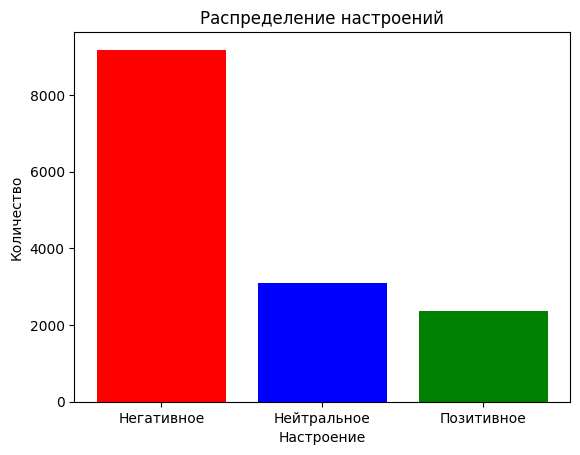

In [9]:
# Отобразим полученный массив
index = [1,2,3]
plt.bar(index,Mood,color=['r','b','g'])
plt.xticks(index,['Негативное','Нейтральное','Позитивное'])
plt.xlabel('Настроение')
plt.ylabel('Количество')
plt.title('Распределение настроений')

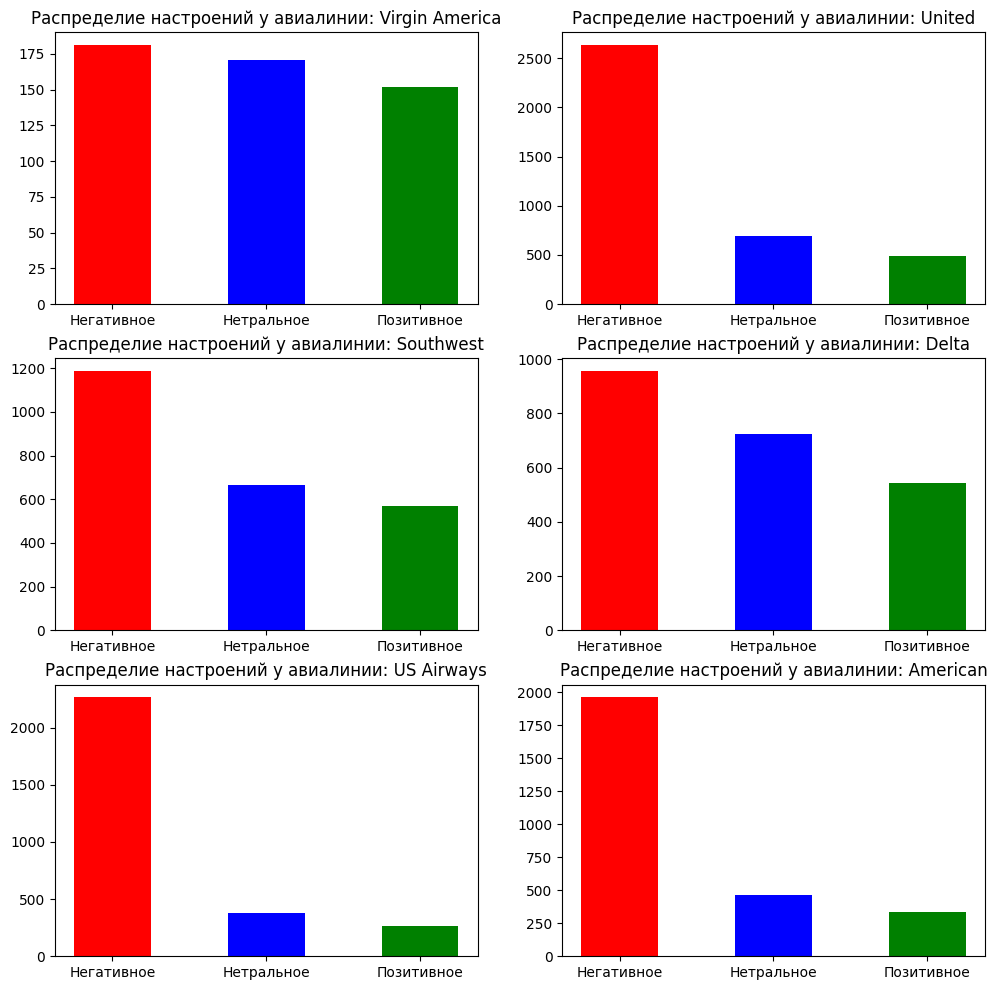

In [10]:
# Разделим массив настроений по авиалиниям

def plot_sub_sentiment(Airline):
    pdf = train_df[train_df['airline']==Airline]
    count = pdf['airline_sentiment'].value_counts()
    Index = [1,2,3]
    color = ['red','blue','green']
    plt.bar(Index,count,width=0.5,color=color)
    plt.xticks(Index,['Негативное','Нетральное','Позитивное'])
    plt.title('Распределие настроений у авиалинии: '+ Airline)
airline_name = train_df['airline'].unique()
plt.figure(1,figsize=(12,12))
for i in range(6):
    plt.subplot(3,2,i+1)
    plot_sub_sentiment(airline_name[i])
plt.show()

In [11]:
#Стандартизация датасета
train_df = train_df[['text', 'airline_sentiment']]
train_df.text = train_df.text.apply(remove_mentions)
train_df.loc[:,'sentiment'] = train_df.airline_sentiment.map({'negative':0,'neutral':1,'positive':2})
train_df = train_df.drop(['airline_sentiment'], axis=1)
train_df.head()

<ipython-input-11-d7c9259629ae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.text = train_df.text.apply(remove_mentions)
<ipython-input-11-d7c9259629ae>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:,'sentiment'] = train_df.airline_sentiment.map({'negative':0,'neutral':1,'positive':2})


,text,sentiment
0,What said.,1
1,plus you've added commercials to the experien...,2
2,I didn't today... Must mean I need to take an...,1
3,"it's really aggressive to blast obnoxious ""en...",0
4,and it's a really big bad thing about it,0


In [12]:
# Поиск максимальной длины входящего предложения

raw_docs_train = train_df["text"].values
sentiment_train = train_df['sentiment'].values
maxLen = len(max(raw_docs_train, key=len).split())

In [13]:
# Разделим датасет на обучающую и тестировочную выборку

X_train, X_test, Y_train, Y_test = train_test_split(raw_docs_train, sentiment_train,
                                                  stratify=sentiment_train,
                                                  random_state=42,
                                                  test_size=0.1, shuffle=True)
print('# Train data samples:', X_train.shape)
print('# Test data samples:', X_test.shape)
assert X_train.shape[0] == Y_train.shape[0]
assert X_test.shape[0] == Y_test.shape[0]

# Train data samples: (13176,)
# Test data samples: (1464,)


In [14]:
# Переведем метки датасета к унитарному виду (0 - Негативное, 1 - Нетральное, 2 - Позитивное)

num_labels = len(np.unique(sentiment_train))
Y_oh_train = to_categorical(Y_train, num_labels)
Y_oh_test = to_categorical(Y_test, num_labels)
print(Y_oh_train.shape)

(13176, 3)


In [15]:
# Загрузим и прочитаем массив GLoVe (GLobal Vectors)

def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('../content/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt')

In [16]:
# Проверка массива словаря GLoVe
word = "cucumber"
index = 289846
print("Индекс слова в ", word, " в словаре: ", word_to_index[word])
print(str(index) + " индекс в словаре это: ", index_to_word[index])

Индекс слова в  cucumber  в словаре:  113317
289846 индекс в словаре это:  potatos


In [17]:
#Функция контвертации текста в массив индексов словаря GLoVe

def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]                                   #Размер обучающей выборки
    # Создание нулевой матрицы X_indices подходяещего размера (≈ 1 line)
    X_indices = np.zeros((m,max_len))
    for i in range(m):                               # перебор обучающих примеров
        # Разбиение предложения на массив слов.
        sentence_words =[word.lower().replace('\t', '') for word in X[i].split(' ') if word.replace('\t', '') != '']
        j = 0
        # Перевод всех слов в индекса словаря
        for w in sentence_words:
            try:
                X_indices[i, j] = word_to_index[w]
            except: 0
            j = j+1
    return X_indices

In [18]:
# Создание слоя встраивания
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1                  # Добавление +1 для сответсвия массива под Keras Embedding(Требование)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # Определение размерности массива GLoVe (= 50)
    # Инициализация матрицы относительно предыдущих преременных
    emb_matrix = np.zeros((vocab_len,emb_dim))
    # Приравнивание каждого индекса матрицы к индексам массива словаря
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
    # Определение количества входных и выходных слоев
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    # Инициализация встроенного слоя
    embedding_layer.build((None,))
    # Установка предварительных весов в встроенный слой
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [19]:
def ltsm_model(input_shape, word_to_vec_map, word_to_index):
    # Определим sentence_indices для обозначения входного значения. Требования: shape input_shape и dtype 'int32'.
    sentence_indices =  Input(shape=input_shape, dtype='int32')
    # Создание встроенного слоя (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    # Протащим sentence_indices через встроенный слой для получения обратного распространения
    embeddings = embedding_layer(sentence_indices)
    # Добавим слой долгой-короткой памяти (LSTM layer) с размерностью 128 с возвратом партий предложений
    # По окончанию получим партии предложений
    X = LSTM(128, return_sequences=True)(embeddings)
    # Добавим метод регуляризации Dropout для отсеивания с коэффициентом отсеивания 0.5
    X = Dropout(0.5)(X)
    # Добавим анологичный слой долгой-короткой памяти (LSTM layer), но без возврата партий предложений
    X = LSTM(128, return_sequences=False)(X)
    # Добавим метод регуляризации Dropout для отсеивания с коэффициентом отсеивания 0.5
    X = Dropout(0.5)(X)
    # Добавление плотного (линейного слоя) с 3 нейронами (0-Негативное,1-Нейтральное,2-Позитивное).
    X = Dense(3, activation=None)(X)
    # Назначение функции активации
    X = Activation('softmax')(X)
    model = Model(inputs=[sentence_indices], outputs=X)
    return model

In [20]:
# Создание рекуррентной нейронной сети
model = ltsm_model((maxLen,), word_to_vec_map, word_to_index)
# Краткая информация о нейронной сети
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26)]              0         
                                                                 
 embedding (Embedding)       (None, 26, 50)            20000050  
                                                                 
 lstm (LSTM)                 (None, 26, 128)           91648     
                                                                 
 dropout (Dropout)           (None, 26, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387   

In [21]:
# Обучение нейронной сети
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
print(X_train_indices.shape)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(X_train_indices, y=Y_oh_train, batch_size=512, epochs=20,
          verbose=1, validation_data=(X_test_indices, Y_oh_test), callbacks=[earlystop])

(13176, 26)
Epoch 1/20
26/26 [==============================] - 19s 577ms/step - loss: 0.8664 - accuracy: 0.6186 - val_loss: 0.8177 - val_accuracy: 0.6407
Epoch 2/20
26/26 [==============================] - 14s 539ms/step - loss: 0.7789 - accuracy: 0.6709 - val_loss: 0.7175 - val_accuracy: 0.6954
Epoch 3/20
26/26 [==============================] - 14s 530ms/step - loss: 0.7029 - accuracy: 0.7159 - val_loss: 0.6659 - val_accuracy: 0.7254
Epoch 4/20
26/26 [==============================] - 15s 573ms/step - loss: 0.6775 - accuracy: 0.7259 - val_loss: 0.6643 - val_accuracy: 0.7439
Epoch 5/20
26/26 [==============================] - 14s 538ms/step - loss: 0.6562 - accuracy: 0.7298 - val_loss: 0.6418 - val_accuracy: 0.7418
Epoch 6/20
26/26 [==============================] - 14s 539ms/step - loss: 0.6372 - accuracy: 0.7379 - val_loss: 0.6343 - val_accuracy: 0.7541
Epoch 7/20
26/26 [==============================] - 15s 557ms/step - loss: 0.6190 - accuracy: 0.7478 - val_loss: 0.6203 - val_accu

In [22]:
#Заготовки для проверки нейронной сети
['Good'] # Хорошо
['Happy'] # Счастливый

['Cold weather today'] # Сегодня прохладная погода
['Warm weather today'] # Сегодня теплая погода

['He is a nice person'] # Он хороший человек
['He is unpleasant person'] # Он неприятный человек

['Bad'] # Плохо
['Awful'] # Ужасный
['Terrible'] # Ужасный

['Neutral'] # Нейтральный
['Green grass'] # Зеленая трава

['Green grass']

In [30]:
#Проверка нейронной сети
x_test = np.array(['Bad'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  str(np.argmax(model.predict(X_test_indices))))

1/1 [==============================] - 0s 59ms/step
Bad 0
